In [1]:
import pandas as pd
import math
import operator
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./天气与运动.csv')
df

,天气,温度,湿度,风况,运动
0,晴,85,85,无,不适合
1,晴,80,90,有,不适合
2,多云,83,78,无,适合
3,有雨,70,96,无,适合
4,有雨,68,80,无,适合
5,有雨,65,70,有,不适合
6,多云,64,65,有,适合
7,晴,72,95,无,不适合
8,晴,69,70,无,适合
9,有雨,75,80,无,适合


In [3]:
# 找出温度的均值，大于他的为热，小于他的为凉
tem_1 = df['温度'] < df.温度.mean()
tem_2 = df['温度'] >= df.温度.mean()
df.loc[tem_1,'温度'] = '凉'
df.loc[tem_2,'温度'] = '热'
#找出湿度的均值，大于他的为湿，小于他的为干
hum_1 = df['湿度'] < df.湿度.mean()
hum_2 = df['湿度'] >= df.湿度.mean()
df.loc[hum_1,'湿度'] = '干'
df.loc[hum_2,'湿度'] = '湿'

In [4]:
df.to_csv('./天气与运动_已处理.csv',index=None)
df2 = pd.read_csv('./天气与运动_已处理.csv')
df2

,天气,温度,湿度,风况,运动
0,晴,热,湿,无,不适合
1,晴,热,湿,有,不适合
2,多云,热,干,无,适合
3,有雨,凉,湿,无,适合
4,有雨,凉,干,无,适合
5,有雨,凉,干,有,不适合
6,多云,凉,干,有,适合
7,晴,凉,湿,无,不适合
8,晴,凉,干,无,适合
9,有雨,热,干,无,适合


# 导入数据生成决策树

In [5]:
def loadDataSet():
    #导入数据
    dataSet = pd.read_csv('./天气与运动_已处理.csv')
    labelSet = list(dataSet.columns.values)
    dataSet = dataSet.values
    dataSet = dataSet.tolist()
    return dataSet, labelSet

In [6]:
dataSet,dataLabels = loadDataSet()

In [7]:
 dataSet

[['晴', '热', '湿', '无', '不适合'],
 ['晴', '热', '湿', '有', '不适合'],
 ['多云', '热', '干', '无', '适合'],
 ['有雨', '凉', '湿', '无', '适合'],
 ['有雨', '凉', '干', '无', '适合'],
 ['有雨', '凉', '干', '有', '不适合'],
 ['多云', '凉', '干', '有', '适合'],
 ['晴', '凉', '湿', '无', '不适合'],
 ['晴', '凉', '干', '无', '适合'],
 ['有雨', '热', '干', '无', '适合'],
 ['晴', '热', '干', '有', '适合'],
 ['多云', '凉', '湿', '有', '适合'],
 ['多云', '热', '干', '无', '适合'],
 ['有雨', '凉', '干', '有', '不适合']]

In [8]:
dataLabels

['天气', '温度', '湿度', '风况', '运动']

In [9]:
def calcShannonEnt(dataSet):
    #样本总个数
    totalNum = len(dataSet)
    #类别集合
    labelSet = {}
    #计算每个类别的样本个数
    for dataVec in dataSet:
        label = dataVec[-1]
        if label not in labelSet.keys():
            labelSet[label] = 0
        labelSet[label] += 1
    shannonEnt = 0
    #计算熵值
    for key in labelSet:
        pi = float(labelSet[key])/totalNum
        shannonEnt -= pi*math.log(pi,2)
    return shannonEnt

In [10]:
def splitDataSet(dataSet, featNum, featvalue):
    '''按给定特征划分数据集'''
    retDataSet = []
    for dataVec in dataSet:
        if dataVec[featNum] == featvalue:
            splitData = dataVec[:featNum]
            splitData.extend(dataVec[featNum+1:])
            retDataSet.append(splitData)
    return retDataSet


In [11]:
def chooseBestFeatToSplit(dataSet):
    '''选择最好的特征划分数据集'''
    featNum = len(dataSet[0]) - 1
    maxInfoGain = 0
    bestFeat = -1
    #计算样本熵值，对应公式中：H(X)
    baseShanno = calcShannonEnt(dataSet)
    #以每一个特征进行分类，找出使信息增益最大的特征
    for i in range(featNum):
        featList = [dataVec[i] for dataVec in dataSet]
        featList = set(featList)
        newShanno = 0
        #计算以第i个特征进行分类后的熵值，对应公式中：H(X|Y)
        for featValue in featList:
            subDataSet = splitDataSet(dataSet, i, featValue)
            prob = len(subDataSet)/float(len(dataSet))
            newShanno += prob*calcShannonEnt(subDataSet)
        #ID3算法：计算信息增益,对应公式中：g(X,Y)=H(X)-H(X|Y)
        infoGain = baseShanno - newShanno
        #找出最大的熵值以及其对应的特征
        if infoGain > maxInfoGain:
            maxInfoGain = infoGain
            bestFeat = i
    return bestFeat

In [12]:
def majorityCnt(labelList):
    '''少数服从多数原则确定该叶子节点类别'''
    labelSet = {}
    # 统计每个类别的样本个数
    for label in labelList:
        if label not in labelSet.keys():
            labelSet[label] = 0
        labelSet[label] += 1
    # iteritems：返回列表迭代器
    # operator.itemgeter(1):获取对象第一个域的值
    # True：降序
    sortedLabelSet = sorted(labelSet.items(), key=operator.itemgetter(1), reverse=True)
    return sortedLabelSet[0][0]

In [13]:
def createDecideTree(dataSet, featName):
    '''创建决策树'''
    #数据集的分类类别
    classList = [dataVec[-1] for dataVec in dataSet]
    #所有样本属于同一类时，停止划分，返回该类别
    if len(classList) == classList.count(classList[0]):
        return classList[0]
    #所有特征已经遍历完，停止划分，返回样本数最多的类别
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    #选择最好的特征进行划分
    bestFeat = chooseBestFeatToSplit(dataSet)
    beatFestName = featName[bestFeat]
    del featName[bestFeat]
    #以字典形式表示树
    DTree = {beatFestName:{}}
    #根据选择的特征，遍历该特征的所有属性值，在每个划分子集上递归调用createDecideTree
    featValue = [dataVec[bestFeat] for dataVec in dataSet]
    featValue = set(featValue)
    for value in featValue:
        subFeatName = featName[:]
        DTree[beatFestName][value] = createDecideTree(splitDataSet(dataSet,bestFeat,value), subFeatName)
    return DTree

# 绘制决策树

In [14]:
def getNumLeafs(tree):
    '''获取叶节点的数目'''
    #统计叶子节点总数
    numLeafs = 0
    #获取第一个节点的分类特征，也就是根节点
    firstFeat = list(tree.keys())[0]
    #得到第一个key对应的内容（以字典方式表示）
    secondDict = tree[firstFeat]
    #递归遍历叶子节点
    for key in secondDict.keys():
        #如果节点类型为字典，说明该节点下仍然是一棵树，调用递归
        if type(secondDict[key]).__name__== 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        #否则该节点为叶节点
        else:
            numLeafs += 1
    return numLeafs

In [15]:
def getTreeDepth(tree):
    '''得到数的深度'''
    #保存最大层数
    maxDepth = 0
    #获取根节点
    firstFeat = list(tree.keys())[0]
    #得到key对应的内容（以字典方式表示）
    secondDict = tree[firstFeat]
    #遍历所有子节点
    for key in secondDict.keys():
        #如果节点类型为字典，说明该节点下仍然是一棵树，调用递归
        if type(secondDict[key]).__name__ == 'dict':
            #子节点深度加一
            thisDepth = 1 + getTreeDepth(secondDict[key])
        #此时是叶子节点
        else:
            thisDepth = 1
        #替换最大层数
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth


In [16]:
def createPlot(tree):
    '''画出决策树'''
    # 定义一块画布，背景为白色
    fig = plt.figure(1, facecolor='white')
    # 清空画布
    fig.clf()
    # 不显示x、y轴刻度
    xyticks = dict(xticks=[], yticks=[])
    # frameon：是否绘制坐标轴矩形
    createPlot.pTree = plt.subplot(111, frameon=False, **xyticks)
    # 计算出决策树的总宽度
    plotTree.totalW = float(getNumLeafs(tree))
    # 计算出决策树的总深度
    plotTree.totalD = float(getTreeDepth(tree))
    # 初始的x轴偏移量，也就是-1/2W，每次向右移动1/W，也就是第一个叶子节点绘制的x坐标为：1/2W，第二个：3/2W，第三个：5/2W，最后一个：(W-1)/2W
    plotTree.xOff = -0.5 / plotTree.totalW
    # 初始的y轴偏移量，每次向下或者向上移动1/D
    plotTree.yOff = 1.0
    # （0.5,1.0）为根节点坐标，调用函数进行绘制节点图像
    plotTree(tree, (0.5, 1.0), '')
    plt.show()

In [17]:
# 为了能够显示中文
matplotlib.rcParams['font.sans-serif'] = ["SimHei"]
matplotlib.rcParams['axes.unicode_minus'] = True
# boxstyle表示文本框类型，sawtooth：锯齿形；fc表示边框线粗细
#决策节点
decisionNode = dict(boxstyle="sawtooth", fc="0.5")
#叶子节点
leafNode = dict(boxstyle="round4", fc="0.5")
# 箭头类型
arrow_args = dict(arrowstyle="<-")

In [18]:
def plotNode(nodeText, centerPt, parentPt, nodeType):
    '''绘制一个节点'''
    # nodeText:要显示的文本；centerPt：文本中心点，即箭头所在的点；parentPt：指向文本的点；nodeType:节点属性
    # ha='center'，va='center':水平、垂直方向中心对齐；bbox：方框属性
    # arrowprops：箭头属性
    # xycoords，textcoords选择坐标系；axes fraction-->0,0是轴域左下角，1,1是右上角
    createPlot.pTree.annotate(nodeText, xy=parentPt, xycoords="axes fraction",
                              xytext=centerPt, textcoords='axes fraction',
                              va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)

In [19]:
def plotMidText(centerPt, parentPt, midText):
    '''计算出父节点和子节点的中间位置，填充信息'''
    #:param cntrPt: 子节点坐标
    #:param parentPt: 父节点坐标
    #:param txtString: 填充的文本信息
    #计算x轴中间位置
    xMid = (parentPt[0] - centerPt[0]) / 2.0 + centerPt[0]
    #计算y轴中间位置
    yMid = (parentPt[1] - centerPt[1]) / 2.0 + centerPt[1]
    #进行绘制
    createPlot.pTree.text(xMid, yMid, midText)

In [20]:
def plotTree(tree, parentPt, nodeTxt):
    '''绘制出树的所有节点，递归绘制'''
    #计算叶子节点个数
    numLeafs = getNumLeafs(tree)
    #获取根节点内容
    firstFeat = list(tree.keys())[0]
    #计算当前节点的x坐标
    centerPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    #绘制该节点与父节点的联系
    plotMidText(centerPt,parentPt,nodeTxt)
    #绘制该节点
    plotNode(firstFeat,centerPt,parentPt,decisionNode)
    #得到当前根节点对应的子树
    secondDict = tree[firstFeat]
    #计算出新的y轴偏移量，向下移动1/D，也就是下一层的绘制y轴
    plotTree.yOff -= 1.0/plotTree.totalD
    #循环遍历所有的key
    for key in secondDict.keys():
        #如果当前的key是字典的话，代表还有子树，则递归遍历
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key],centerPt,str(key))
        #如果当前节点的子节点是叶子节点，则绘制该叶节点
        else:
            # 计算新的x轴偏移量，也就是下个叶子绘制的x轴坐标向右移动了1/W
            plotTree.xOff += 1.0/plotTree.totalW
            # 绘制叶子节点
            plotNode(secondDict[key], (plotTree.xOff,plotTree.yOff),centerPt,leafNode)
            #绘制叶子节点和父节点的中间连线内容
            plotMidText((plotTree.xOff,plotTree.yOff),centerPt,str(key))
    #返回递归之前，需要将y轴的偏移量增加，向上移动1/D，也就是返回去绘制上一层的y轴
    plotTree.yOff += 1.0/plotTree.totalD

决策树模型：
{'天气': {'多云': '适合', '晴': {'湿度': {'干': '适合', '湿': '不适合'}}, '有雨': {'风况': {'有': '不适合', '无': '适合'}}}}


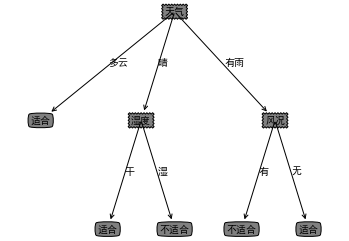

In [21]:
myTree = createDecideTree(dataSet,dataLabels)
print("决策树模型：")
print(myTree)
createPlot(myTree)